# A numerical variability approach to results stability tests and its application to neuroimaging

This Jupyter notebook reproduces figures present in the paper.

In [2]:
import glob
import os

import joblib
import nibabel
import nilearn.masking
import numpy as np
import pandas as pd
import significantdigits as sdg
import tqdm
from joblib import Memory, Parallel, delayed
import plotly.express as px
import plotly.graph_objects as go
import nilearn.plotting
import matplotlib.pyplot as plt
from matplotlib import cm

## Table II. Dimensions, voxels resolutions, age and sex of each subject in the dataset.

In [3]:
data = {
    "Index": [1, 2, 3, 4, 5, 6, 7, 8],
    "Dataset": [
        "ds000256",
        "ds000256",
        "ds001600",
        "ds001748",
        "ds001748",
        "ds001771",
        "ds002338",
        "ds002338",
    ],
    "Subject": [
        "sub-CTS201",
        "sub-CTS210",
        "sub-1",
        "sub-adult15",
        "sub-adult16",
        "sub-36",
        "sub-xp201",
        "sub-xp207",
    ],
    "Dimension (x, y, z)": [
        "256 × 256 × 256",
        "224 × 256 × 256",
        "176 × 256 × 256",
        "176 × 240 × 256",
        "176 × 240 × 256",
        "256 × 320 × 320",
        "176 × 512 × 512",
        "176 × 512 × 512",
    ],
    "Voxel resolution (x, y, z)": [
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "1.0 × 1.0 × 1.0",
        "0.8 × 0.8 × 0.8",
        "1.0 × 0.5 × 0.5",
        "1.0 × 0.5 × 0.5",
    ],
    "Data type": [
        "int16",
        "int16",
        "int16",
        "float32",
        "float32",
        "int16",
        "int16",
        "int16",
    ],
    "Age (years)": [8.68, 7.63, "-", 21, 21, 22, 41, 39],
    "Sex": ["M", "F", "-", "M", "F", "F", "F", "M"],
}

subjects_table = pd.DataFrame(data)

def get_index(dataset, subject):
    return subjects_table[
        (subjects_table["Dataset"] == dataset) & (subjects_table["Subject"] == subject)
    ]["Index"].values[0]

def get_dataset_subject(index):
    return subjects_table[subjects_table["Index"] == index][["Dataset", "Subject"]].values[0]

subjects_table

,Index,Dataset,Subject,"Dimension (x, y, z)","Voxel resolution (x, y, z)",Data type,Age (years),Sex
0,1,ds000256,sub-CTS201,256 × 256 × 256,1.0 × 1.0 × 1.0,int16,8.68,M
1,2,ds000256,sub-CTS210,224 × 256 × 256,0.8 × 0.8 × 0.8,int16,7.63,F
2,3,ds001600,sub-1,176 × 256 × 256,1.0 × 1.0 × 1.0,int16,-,-
3,4,ds001748,sub-adult15,176 × 240 × 256,1.0 × 1.0 × 1.0,float32,21,M
4,5,ds001748,sub-adult16,176 × 240 × 256,1.0 × 1.0 × 1.0,float32,21,F
5,6,ds001771,sub-36,256 × 320 × 320,0.8 × 0.8 × 0.8,int16,22,F
6,7,ds002338,sub-xp201,176 × 512 × 512,1.0 × 0.5 × 0.5,int16,41,F
7,8,ds002338,sub-xp207,176 × 512 × 512,1.0 × 0.5 × 0.5,int16,39,M


In [8]:
# Compute significant digits for each perturbation, subject and FWHM

def load_T1w(directory, dataset, subject):
    t1 = f"{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    path = os.path.join(directory, f"*{dataset}*", "**", "anat", t1)
    return glob.glob(path, recursive=True)


def load_brain_mask(directory, dataset, subject):
    mask = f"{subject}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    path = os.path.join(directory, f"*{dataset}*", "**", "anat", mask)
    return glob.glob(path, recursive=True)


def compute_brain_mask_union(brain_masks):
    UNION = 0
    mask_union = nilearn.masking.intersect_masks(brain_masks, threshold=UNION)
    return mask_union


def apply_mask(t1ws, mask_union, smoothing_fwhm=None):
    import nilearn.masking

    if smoothing_fwhm == 0:
        smoothing_fwhm = None
    t1w_preproc = np.fromiter(
        (
            nilearn.masking.apply_mask(t1w, mask_union, smoothing_fwhm=smoothing_fwhm)
            for t1w in t1ws
        ),
        dtype=np.dtype((np.float32, np.count_nonzero(mask_union.get_fdata()))),
    )
    return t1w_preproc


def get_output_path(cache, perturbation, index, fwhm, normalized):
    normalized = "normalized" if normalized else "unnormalized"
    return os.path.join(
        cache, normalized, f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz"
    )

def compute_significant_digits_normalized(voxels, mask_union, output_normalized):
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_normalized, sig=sig, mask=mask_union)


def compute_significant_digits_unnormalized(voxels, mask_union, output_unnormalized):
    iterator = ((v - v.min()) / (v.max() - v.min()) for v in voxels)
    voxels = np.fromiter(iter=iterator, dtype=np.dtype((np.float32, voxels.shape[1:])))
    reference = np.mean(voxels, axis=0)
    sig = sdg.significant_digits(voxels, reference=reference)
    np.savez_compressed(output_unnormalized, sig=sig, mask=mask_union)


def compute_significant_digits(
    t1ws, mask_union, fwhm, perturbation, index, cache, force=False
):
    output_normalized = get_output_path(cache, perturbation, index, fwhm, True)
    output_unnormalized = get_output_path(cache, perturbation, index, fwhm, False)
    voxels = apply_mask(t1ws, mask_union, fwhm)
    if not os.path.exists(output_normalized) or force:
        compute_significant_digits_normalized(voxels, mask_union, output_normalized)
    if not os.path.exists(output_unnormalized) or force:
        compute_significant_digits_unnormalized(voxels, mask_union, output_unnormalized)


for perturbation in ["rr", "rs"]:
    print(f"Perturbation {perturbation}")
    for index in subjects_table["Index"]:
        print("Preprocessing subject", index)
        directory = f"outputs/20.2.1/{perturbation}"
        fwhms = []
        for i in range(0, 21):
            output_normalized = get_output_path("significant_digits", perturbation, index, i, True)
            output_unnormalized = get_output_path("significant_digits", perturbation, index, i, False)
            if not os.path.exists(output_normalized) or not os.path.exists(output_unnormalized):
                fwhms.append(i)
            else:
                continue

        if len(fwhms) == 0:
            print("All FWHMs already computed")
            continue
        
        dataset, subject = get_dataset_subject(index)        
        t1ws = load_T1w(directory, dataset, subject)
        brain_masks = load_brain_mask(directory, dataset, subject)
        mask_union = compute_brain_mask_union(brain_masks)

        def producer():
            for fwhm in range(0, 21):
                yield (
                    t1ws,
                    mask_union,
                    fwhm,
                    perturbation,
                    index,
                    "significant_digits",
                )

        # Adjust n_jobs according to ressources available
        Parallel(n_jobs=8)(
            delayed(compute_significant_digits)(*args)
            for args in tqdm.tqdm(producer(), unit="FWHM")
        )

Perturbation rr
Preprocessing subject 1
All FWHMs already computed
Preprocessing subject 2
All FWHMs already computed
Preprocessing subject 3
All FWHMs already computed
Preprocessing subject 4
All FWHMs already computed
Preprocessing subject 5
All FWHMs already computed
Preprocessing subject 6
All FWHMs already computed
Preprocessing subject 7
All FWHMs already computed
Preprocessing subject 8
All FWHMs already computed
Perturbation rs
Preprocessing subject 1
All FWHMs already computed
Preprocessing subject 2
All FWHMs already computed
Preprocessing subject 3
All FWHMs already computed
Preprocessing subject 4
All FWHMs already computed
Preprocessing subject 5
All FWHMs already computed
Preprocessing subject 6
All FWHMs already computed
Preprocessing subject 7
All FWHMs already computed
Preprocessing subject 8
All FWHMs already computed


In [9]:
def compute_sig_mean(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = os.path.join(
        "significant_digits",
        normalized,
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz",
    )
    data = np.load(npz)
    sig = data["sig"]
    return np.mean(sig)


rr = {
    index: [compute_sig_mean("rr", index, i, normalized=False) for i in range(0, 21)]
    for index in subjects_table["Index"]
}
rs = {
    index: [compute_sig_mean("rs", index, i, normalized=False) for i in range(0, 21)]
    for index in subjects_table["Index"]
}
rr_norm = {
    index: [compute_sig_mean("rr", index, i, normalized=True) for i in range(0, 21)]
    for index in subjects_table["Index"]
}
rs_norm = {
    index: [compute_sig_mean("rs", index, i, normalized=True) for i in range(0, 21)]
    for index in subjects_table["Index"]
}

In [20]:
def unmask(perturbation, index, fwhm, normalized=True):
    normalized = "normalized" if normalized else "unnormalized"
    npz = os.path.join(
        "significant_digits",
        normalized,
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.npz",
    )
    data = np.load(npz, allow_pickle=True)
    sig, mask_union = data["sig"], data["mask"]
    return nilearn.masking.unmask(sig, mask_union.item())


def view_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=False,
    normalized=True,
):
    if discrete:
        cmap = plt.colormaps.get_cmap("RdYlGn").resampled(np.abs(vmax - vmin))
    else:
        cmap = plt.colormaps.get_cmap("RdYlGn")
    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )
    return nilearn.plotting.view_img(
        sig_img_thresholded,
        cmap=cmap,
        symmetric_cmap=False,
        black_bg=True,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        title=title,
    )


def plot_ieee_brain(index, fwhm):
    output_path = os.path.join(
        "significant_digits",
        "figures",
        "ieee",
        f"Subject-{index}_FWHM-{fwhm}.png",
    )
    if os.path.exists(output_path):
        return
    if fwhm == 0:
        fwhm = None
    directory = f"outputs/20.2.1/ieee"
    dataset, subject = get_dataset_subject(index)
    t1w = load_T1w(directory, dataset, subject)[0]
    brain_mask = load_brain_mask(directory, dataset, subject)[0]
    voxel = nilearn.masking.apply_mask(t1w, brain_mask, smoothing_fwhm=fwhm)
    t1w_masked = nilearn.masking.unmask(voxel, brain_mask)
    return nilearn.plotting.plot_anat(
        t1w_masked,
        output_file=output_path,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        black_bg=True,
        bg_img=None,
    )


def plot_significant_digits_brain(
    perturbation,
    index,
    fwhm,
    title=None,
    vmax=12,
    vmin=0,
    discrete=True,
    normalized=True,
):
    if discrete:
        cmap = plt.colormaps.get_cmap("RdYlGn").resampled(np.abs(vmax - vmin))
    else:
        cmap = plt.colormaps.get_cmap("RdYlGn")
    output_path = os.path.join(
        "significant_digits",
        "figures",
        "normalized" if normalized else "unnormalized",
        f"{perturbation}-Subject-{index}_FWHM-{fwhm}.png",
    )
    if os.path.exists(output_path):
        return

    sig_img = unmask(perturbation, index, fwhm, normalized=normalized)
    voxels = sig_img.get_fdata()
    sig_img_thresholded = nibabel.Nifti1Image(
        np.where(voxels <= 0, 0, voxels), sig_img.affine
    )

    return nilearn.plotting.plot_anat(
        sig_img_thresholded,
        cmap=cmap,
        # symmetric_cmap=False,
        black_bg=True,
        threshold=0.01,
        vmin=vmin,
        vmax=vmax,
        bg_img=None,
        cut_coords=(0, 0, 0),
        draw_cross=False,
        title=title,
        output_file=output_path,
    )


def ieee_producer():
    for index in subjects_table["Index"]:
        for fwhm in range(0, 21):
            yield (index, fwhm)

def producer():
    for perturbation in ["rr", "rs"]:
        for index in subjects_table["Index"]:
            for fwhm in range(0, 21):
                yield (perturbation, index, fwhm)

Parallel(n_jobs=16)(delayed(plot_ieee_brain)(*args) for args in tqdm.tqdm(ieee_producer(), unit="image"))

Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=False)
    for args in tqdm.tqdm(producer(), unit="image")
)
none=Parallel(n_jobs=16)(
    delayed(plot_significant_digits_brain)(*args, discrete=True, normalized=True)
    for args in tqdm.tqdm(producer(), unit="image")
)













168image [00:01, 159.53image/s]































































336image [02:18,  2.42image/s]































































336image [02:15,  2.49image/s]


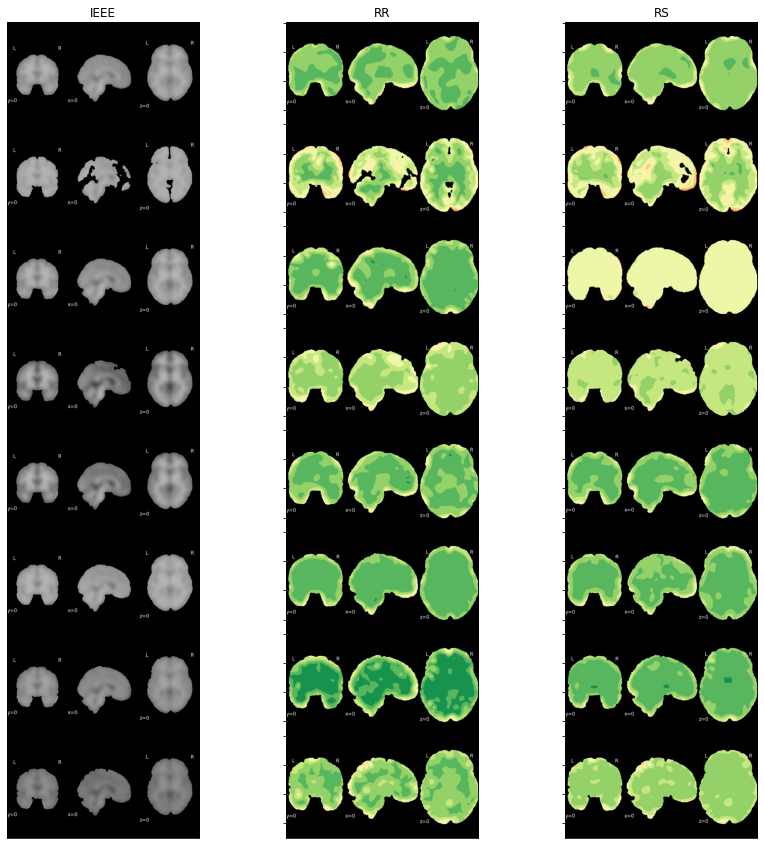

In [30]:
import matplotlib.pyplot as plt


def create_grid_numerical_variability(normalized, fwhm):
    plt.close()
    prefix = os.path.join("significant_digits", "figures")
    normalized = "normalized" if normalized else "unnormalized"

    f, axarr = plt.subplots(
        8,
        3,
        figsize=(15, 15),
        sharex=True,
        sharey=True,
        gridspec_kw={"hspace": 0, "wspace": 0},
    )

    for row, index in enumerate(subjects_table["Index"], start=1):
        ieee_filename = os.path.join(prefix, "ieee", f"Subject-{index}_FWHM-{fwhm}.png")
        rr_filename = os.path.join(
            prefix, normalized, f"rr-Subject-{index}_FWHM-{fwhm}.png"
        )
        rs_filename = os.path.join(
            prefix, normalized, f"rs-Subject-{index}_FWHM-{fwhm}.png"
        )

        ieee_img = plt.imread(ieee_filename)
        rr_img = plt.imread(rr_filename)
        rs_img = plt.imread(rs_filename)

        axarr[row - 1, 0].set_title(f"IEEE")
        axarr[row - 1, 0].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 0].tick_params(
            axis="y", right=False, labelright=False, left=False, labelleft=False
        )
        axarr[row - 1, 1].set_title(f"RR")
        axarr[row - 1, 1].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )
        axarr[row - 1, 2].set_title(f"RS")
        axarr[row - 1, 2].tick_params(
            axis="x", bottom=False, labelbottom=False, top=False, labeltop=False
        )

        axarr[row - 1, 0].imshow(ieee_img)
        axarr[row - 1, 1].imshow(rr_img)
        axarr[row - 1, 2].imshow(rs_img)

    plt.subplots_adjust(wspace=0, hspace=0)
    
create_grid_numerical_variability(normalized=True, fwhm=15)

## Figure 3: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM = 15 mm.

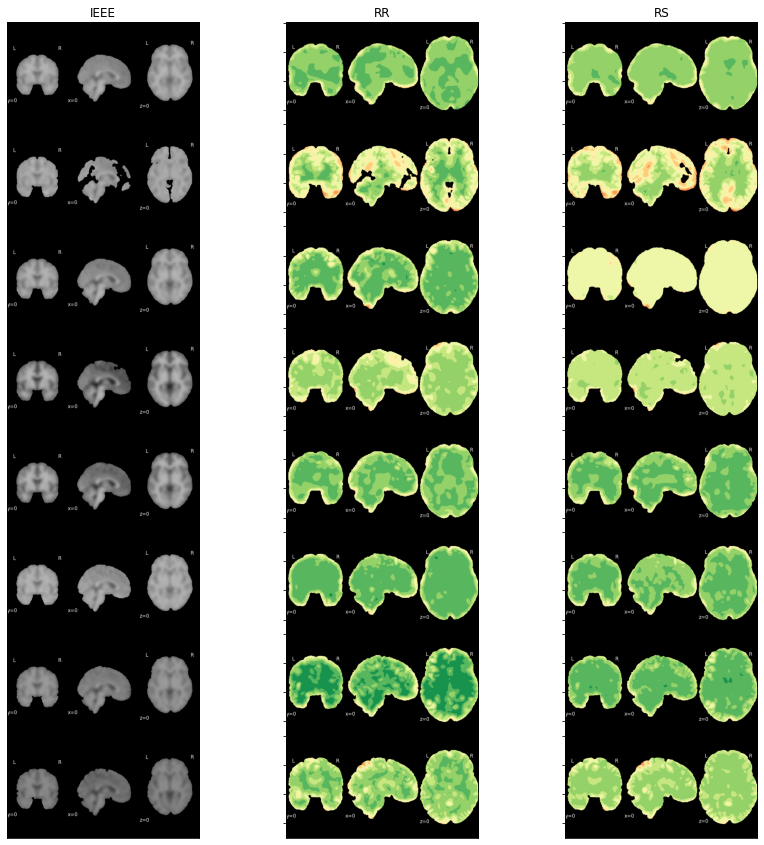

In [25]:
create_grid_numerical_variability(normalized=True, fwhm=0)

## Figure 3: Numerical variability measured for subjects 1 to 8 (from top to bottom) across n=30 perturbed samples, with FWHM=0mm. 

In [16]:
plot_significant_digits_brain('rr', 2, 15, title='Subject 1, FWHM 0', normalized=False)

In [32]:
def plot_significant_digits(sig_data, title):
    sig_min = min(min(v) for v in rr.values())
    sig_max = max(max(v) for v in rr.values())
    fig = px.line(sig_data, markers=True, title=title)
    fig.update_xaxes(title="FWHM (mm)")
    fig.update_yaxes(title="Significant bits")
    fig.update_legends(title="Subjects")
    fig.add_hline(y=sig_min, line_dash="dot", line_color="black", opacity=0.5, annotation_text=f"{sig_min:.2f}")
    fig.add_hline(y=sig_max, line_dash="dot", line_color="black", opacity=0.5, annotation_text=f"{sig_max:.2f}")    
    return fig

## Figure 2: Voxel-wise means of significant bits measured across n=30 perturbed samples for RR and RS perturbations and 8 subjects

In [33]:
## Figure 2: Voxel-wise means of significant bits measured across n=30 perturbed samples for RR and RS perturbations and 8 subjectssignificant_digits(rr, "RR")
plot_significant_digits(rr, "RR")

In [34]:
plot_significant_digits(rs, "RS")

Load pickle files

- `subjects`: Subjects analysis 

In [39]:
def load_pickle_files(files):
    """
    Load all pickle files in a directory
    """
    df = pd.concat(pd.DataFrame(pd.read_pickle(file)) for file in files)
    return df

template_experiments = glob.glob("pickles/template/*.pkl", recursive=True)
template_df = load_pickle_files(template_experiments)
template_df

,reference_version,reference_architecture,reference_perturbation,reference_prefix,reference_dataset,reference_subject,reference_template,reference_sample_size,reference_fwhm,reference_mask,...,target_dataset,target_subject,target_template,target_filename,kth_round,nb_round,confidence,reject,tests,method
0,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.999,0,3651571,pce
1,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.995,0,3651571,pce
2,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.990,0,3651571,pce
3,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.950,0,3651571,pce
4,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.900,0,3651571,pce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.700,0,1882780,fwe-bonferroni
2596,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.650,0,1882780,fwe-bonferroni
2597,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.600,0,1882780,fwe-bonferroni
2598,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.550,0,1882780,fwe-bonferroni


In [72]:
template_df.groupby(["reference_version", "reference_dataset", "reference_subject", "reference_perturbation", "reference_template", "reference_fwhm", "target_dataset", "target_subject", "target_template", "confidence"], group_keys=True).apply(lambda x: x)
bonferroni = template_df[template_df["method"] == "fwe-bonferroni"]
bonferroni

,reference_version,reference_architecture,reference_perturbation,reference_prefix,reference_dataset,reference_subject,reference_template,reference_sample_size,reference_fwhm,reference_mask,...,target_dataset,target_subject,target_template,target_filename,kth_round,nb_round,confidence,reject,tests,method
117,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.999,0,3651571,fwe-bonferroni
118,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.995,0,3651571,fwe-bonferroni
119,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.990,0,3651571,fwe-bonferroni
120,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.950,0,3651571,fwe-bonferroni
121,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds001771,sub-36,MNI152NLin2009cAsym,1,0,union,...,ds001771,sub-36,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.900,0,3651571,fwe-bonferroni
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.700,0,1882780,fwe-bonferroni
2596,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.650,0,1882780,fwe-bonferroni
2597,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.600,0,1882780,fwe-bonferroni
2598,20.2.1,narval-AMD,ieee,outputs/20.2.1/ieee,ds000256,sub-CTS201,MNI152NLin2009cAsym,1,19,union,...,ds000256,sub-CTS201,MNI152NLin2009cAsymNoised0200,/home/yohan/Work/fmriprep-reproducibility/resu...,1,1,0.550,0,1882780,fwe-bonferroni


In [74]:
# Get number of failing tests for each subject, template, perturbation and confidence level
bonferroni[bonferroni["reference_perturbation"]!='ieee']

,reference_version,reference_architecture,reference_perturbation,reference_prefix,reference_dataset,reference_subject,reference_template,reference_sample_size,reference_fwhm,reference_mask,...,target_dataset,target_subject,target_template,target_filename,kth_round,nb_round,confidence,reject,tests,method
